In [43]:
import datetime as dt
import os, sys
import netCDF4 as nc
import matplotlib as mpl
import numpy as np
import numpy.ma as ma
from scipy.spatial import distance
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import cm
import matplotlib.colors as mpl_colors
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import matplotlib.mlab as mlab


from salishsea_tools import geo_tools, viz_tools

get_ipython().magic('matplotlib inline')

In [31]:
matplotlib.rcParams['font.size'] = 30

In [3]:
#Parameters

cmap = plt.get_cmap('nipy_spectral')
cmap.set_bad('burlywood')

H = 24 #One day in hours

#Ariane parameters
tunit= 3600

outint = 20 * 60 # 20 min in seconds

pph = int(tunit / outint) #points per hour

lmt = 1896 #points per particle


basedir = "/ocean/gsgarbi/analysis-giorgio/time_series/results2016/"

plotsdir = "/ocean/gsgarbi/analysis-giorgio/time_series/results2016/plots"

In [26]:
# Get points for the year - this process should take about 42min for 12 months (3.5min per month)

path = "/ocean/gsgarbi/analysis-giorgio/time_series/results2016/"

dirs = os.listdir( path )

dirs.sort()

dirs = dirs [0:12]


In [5]:
#function to get points from an indiviual month

def get_pts(direct, nday):
    
    position = nday * pph * H # d * num/h * h/d = num
    
    points = []
        
    particle = 1 #start particle counter
    
    start = dt.datetime.now()
    print ("start {}: ".format(direct), start)


    with open(basedir + direct + "/traj.txt") as file:

        for i, line in enumerate(file):

            line = line.strip('\n').split()

            line = [float(k) for k in line]

            line = np.array(line)


            if line[0] == particle:
                index = i + position
                particle += 1

            if i == index:
                points.append (line)
                
        print ("time: ", dt.datetime.now() - start)
                
                
    return points

In [5]:
# # test cell

# year0 = year1 = year2 = [] #for each depth

# jan = get_pts("/ocean/gsgarbi/analysis-giorgio/time_series/results2016/20160101_20160131_427d/")

# feb = get_pts("/ocean/gsgarbi/analysis-giorgio/time_series/results2016/20160201_20160229_401d/")


# year0 = jan[0::3] + feb[0::3]
# year1 = jan[1::3] + feb[1::3]
# year2 = jan[2::3] + feb[2::3]



In [6]:
def plot(points, title = 'title', picname = "noname"):
    
    Iona = (-123.30898284912109, 49.187351226806641)
    S15 = (-123.3114, 49.130412)
    S16 = (-123.317415, 49.1214)
    xl=(-126.2,-122.2)
    yl=(47.1,51)




    #prepare plot and constants
    plt.clf()
    start = dt.datetime.now()
    print ("start: ", start)
    mesh = nc.Dataset("/ocean/gsgarbi/mesh_mask_downbyone2.nc")
    tmask=np.copy(mesh.variables['tmask'])
    mesh.close()
    fb=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
    nav_lon=np.copy(fb.variables['nav_lon'])
    nav_lat=np.copy(fb.variables['nav_lat'])
    fb.close()
    
    lonlim=[np.min(nav_lon),np.max(nav_lon)]
    latlim=[np.min(nav_lat),np.max(nav_lat)]


    griddata=0.0*tmask[0,0,:,:]

    np.shape(points)[0]



    griddata, iedges, jedges = np.histogram2d(points[:,1],points[:,2],bins=[100,200],range=[lonlim,latlim])


    Jedges,Iedges=np.meshgrid(jedges,iedges)
    


    fig, axs = plt.subplots(1,1,figsize=(9,8))
    mesh0 = axs.pcolormesh(Iedges,Jedges,griddata,cmap=cmap)
    mesh0.set_clim(vmin = 0, vmax = 40)
    axs.set_xlim(xl)
    axs.set_ylim(yl)
    pos=axs.get_position()
    pos2=(pos.bounds[0],pos.bounds[1],pos.bounds[2]-.05,pos.bounds[3])
    axs.set_position(pos2)
    axs2 = plt.axes(pos2)
    viz_tools.set_aspect(axs,coords='map')
    mesh1=axs2.pcolormesh(nav_lon,nav_lat,np.ma.masked_where(tmask[0,0,:,:]==1,tmask[0,0,:,:]),cmap='YlOrRd')
    axs2.set_xlim(xl)
    axs2.set_ylim(yl)
    axs2.patch.set_alpha(0)
    viz_tools.set_aspect(axs2,coords='map')
    axsCB=plt.axes((pos2[0]+pos2[3],pos2[1],.02,pos2[3]))
    cbar = fig.colorbar(mesh0,cax=axsCB)
    cbar.set_label ("Counts")
    
    axs.set_title(title)

    
    plt.savefig(picname)
    
    print ("We have a total of {} trajectories".format(np.sum(griddata)))

In [7]:
def separate(nday):
    year1 = []
    year2 = []
    year3 = []

    for file in dirs:
        month = get_pts(file, nday)
        year1 += month [0::3]
        year2 += month [1::3]
        year3 += month [2::3]
        
    return (year1, year2, year3)




In [8]:
def plot_hist (pts, nday, init_depth):
    
    
    npyear=np.array(pts)

    df=pd.DataFrame(data=npyear[:,1:],index=npyear[:,0],columns=['Lon','Lat','Z','tind'])

    df2=df[(df.Lat>49.1) & (df.Lat<49.35)]
    
    fig, axs = plt.subplots(1,1,figsize=(9,8))

    axs.hist(df2['Z'],50,orientation='horizontal')
    
    
    
    plt.xlabel('Count')
    plt.ylabel('Depth (m)')
    
    title = ("Length of trajectory: {} days\n"
                    "Initial depth: {}m".format(nday, init_depth))
    
    plt.title ( title )
    
    plt.savefig( "/ocean/gsgarbi/analysis-giorgio/2017apr20_presentation/hist_{}d_{}m".format(nday, init_depth) )

In [44]:
def plot_hist_together (pts1, pts2, pts3, nday, init_depth):
    
    fig, axs = plt.subplots(1,1,figsize=(9,8))
    
    colors = ['lightblue', 'salmon', 'yellow']
    
    idepth = [45, 59, 77]
    
    labels = ["45m", "59m", "77m"]
    
#     alphas = [0.2, 0.4, 0.8]
    
    for i, pts in enumerate([pts1, pts2, pts3]):
        npyear=np.array(pts)

        df=pd.DataFrame(data=npyear[:,1:],index=npyear[:,0],columns=['Lon','Lat','Z','tind'])

        df2=df[(df.Lat>49.1) & (df.Lat<49.35)]

        bins = 50

        axs.hist(df2['Z'],bins,orientation='horizontal', color = colors[i], alpha = 0.5, label = labels[i])
        
        mu = idepth[i]
        
        sigma
        
        # add a 'best fit' line
        y = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins, y, 'r--')



        plt.xlabel('Count')
        plt.ylabel('Depth (m)')
    
    title = ("Length of trajectory: {} days\n"
                    "Initial depth: {}m".format(nday, init_depth))
    
    plt.title ( title )
    
    plt.savefig( "/ocean/gsgarbi/analysis-giorgio/2017apr20_presentation/hist_{}d_{}m".format(nday, init_depth) )

In [49]:
def alt_plot (pts1, pts2, pts3, nday, init_depth):
#     bins = numpy.linspace(-10, 10, 100)

    bins = 50

    plt.hist(pts1, bins, alpha=0.5, label='45')
    plt.hist(pts2, bins, alpha=0.5, label='59')
    plt.hist(pts3, bins, alpha=0.5, label='77')
    plt.legend(loc='upper right')
    plt.show()

start 20160101_20160131_427d:  2017-04-21 15:23:28.298315
time:  0:03:28.438596
start 20160201_20160229_401d:  2017-04-21 15:26:56.737741
time:  0:03:09.837692
start 20160301_20160331_355d:  2017-04-21 15:30:06.576442
time:  0:02:56.025101
start 20160401_20160430_325d:  2017-04-21 15:33:02.602590
time:  0:02:36.287681
start 20160501_20160531_294d:  2017-04-21 15:35:38.891089
time:  0:02:27.699496
start 20160601_20160630_264d:  2017-04-21 15:38:06.591396
time:  0:02:08.222540
start 20160701_20160731_252d:  2017-04-21 15:40:14.814822
time:  0:02:05.637508
start 20160801_20160831_217d:  2017-04-21 15:42:20.452958
time:  0:01:52.806897
start 20160901_20160930_172d:  2017-04-21 15:44:13.261390
time:  0:01:22.594530
start 20161001_20161031_141d:  2017-04-21 15:45:35.856763
time:  0:01:09.332901
start 20161101_20161130_111d:  2017-04-21 15:46:45.190602
time:  0:00:53.155402
start 20161201_20161231_95d:  2017-04-21 15:47:38.347110
time:  0:00:46.791394


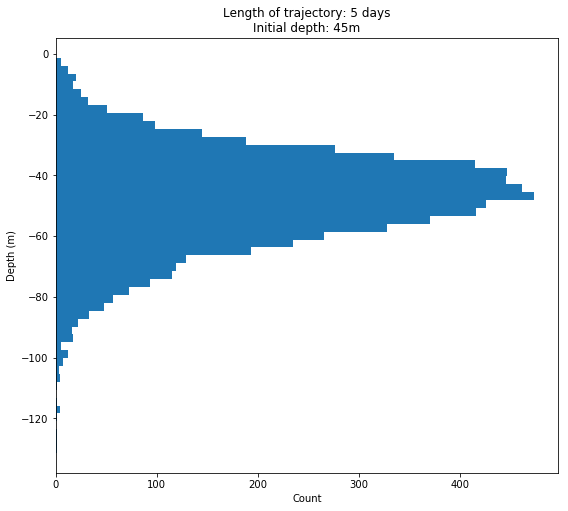

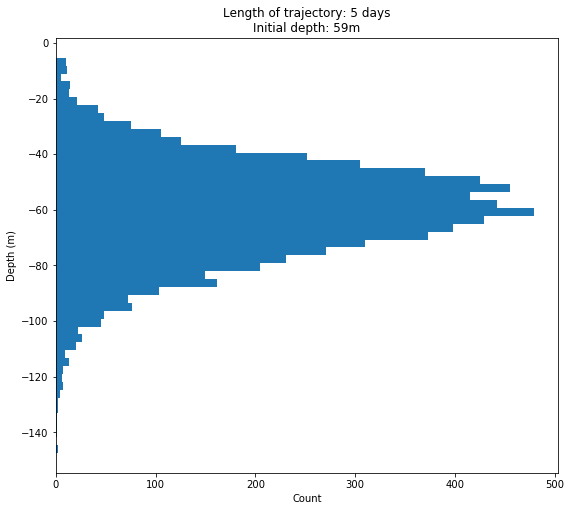

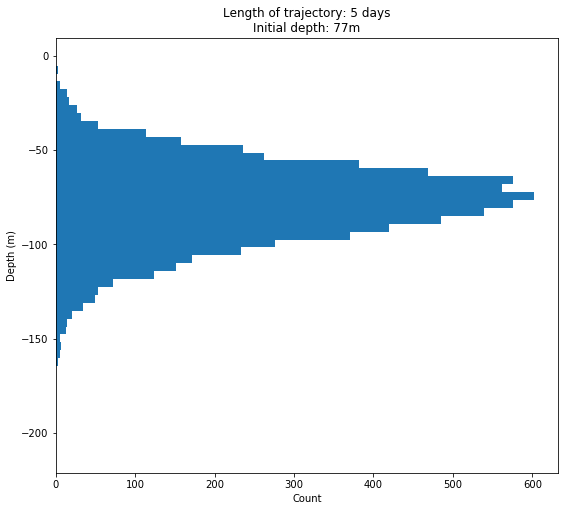

In [9]:
nday = 5

syear = separate(nday)

year1 = syear[0]
year2 = syear[1]
year3 = syear[2]

plot_hist(pts = year1, nday = nday, init_depth = 45)
plot_hist(pts = year2, nday = nday, init_depth = 59)
plot_hist(pts = year3, nday = nday, init_depth = 77)

start 20160101_20160131_427d:  2017-04-21 15:48:26.709514
time:  0:03:32.676906
start 20160201_20160229_401d:  2017-04-21 15:51:59.387466
time:  0:03:10.641988
start 20160301_20160331_355d:  2017-04-21 15:55:10.030270
time:  0:03:01.424845
start 20160401_20160430_325d:  2017-04-21 15:58:11.456128
time:  0:02:36.956977
start 20160501_20160531_294d:  2017-04-21 16:00:48.413896
time:  0:02:27.625447
start 20160601_20160630_264d:  2017-04-21 16:03:16.040212
time:  0:02:07.348720
start 20160701_20160731_252d:  2017-04-21 16:05:23.389836
time:  0:02:05.529994
start 20160801_20160831_217d:  2017-04-21 16:07:28.920596
time:  0:01:56.203203
start 20160901_20160930_172d:  2017-04-21 16:09:25.124978
time:  0:01:30.168661
start 20161001_20161031_141d:  2017-04-21 16:10:55.295999
time:  0:01:13.355813
start 20161101_20161130_111d:  2017-04-21 16:12:08.652607
time:  0:00:54.772501
start 20161201_20161231_95d:  2017-04-21 16:13:03.426056
time:  0:00:48.978694


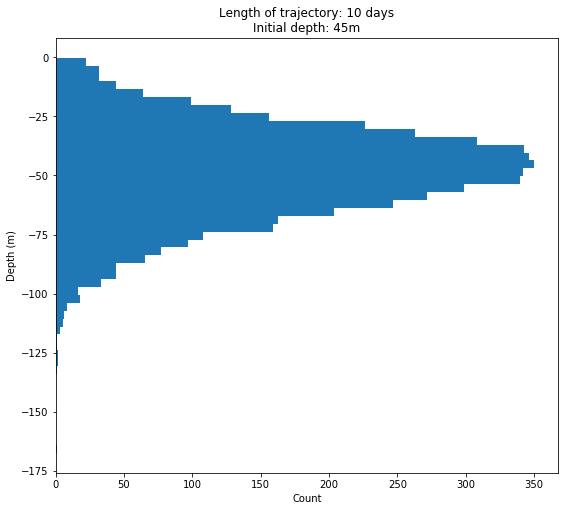

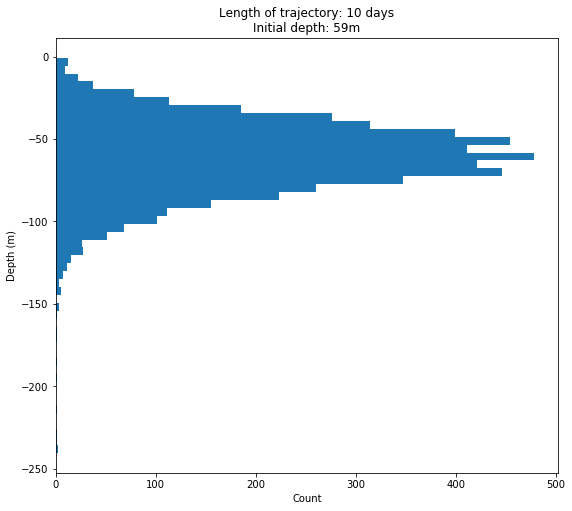

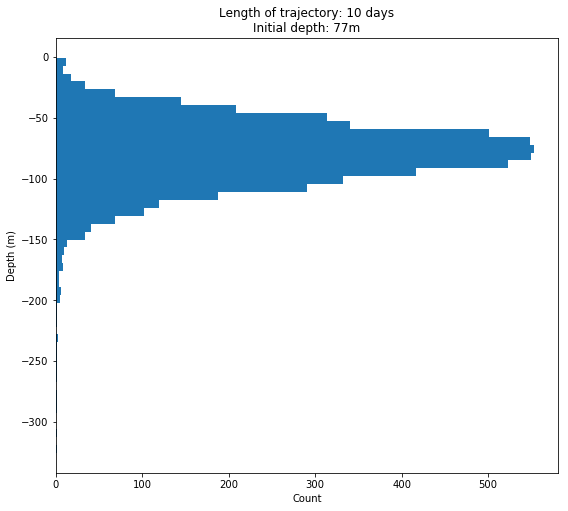

In [10]:
nday = 10

syear = separate(nday)

year1 = syear[0]
year2 = syear[1]
year3 = syear[2]

plot_hist(pts = year1, nday = nday, init_depth = 45)
plot_hist(pts = year2, nday = nday, init_depth = 59)
plot_hist(pts = year3, nday = nday, init_depth = 77)

In [12]:
nday = 20

syear = separate(nday)

start 20160101_20160131_427d:  2017-04-21 16:15:58.376980
time:  0:03:39.347261
start 20160201_20160229_401d:  2017-04-21 16:19:37.725234
time:  0:03:29.511678
start 20160301_20160331_355d:  2017-04-21 16:23:07.238236
time:  0:03:37.124985
start 20160401_20160430_325d:  2017-04-21 16:26:44.364687
time:  0:02:57.495741
start 20160501_20160531_294d:  2017-04-21 16:29:41.861843
time:  0:02:40.744425
start 20160601_20160630_264d:  2017-04-21 16:32:22.607421
time:  0:02:21.372777
start 20160701_20160731_252d:  2017-04-21 16:34:43.981376
time:  0:02:15.527306
start 20160801_20160831_217d:  2017-04-21 16:36:59.509649
time:  0:01:52.118075
start 20160901_20160930_172d:  2017-04-21 16:38:51.629097
time:  0:01:26.050344
start 20161001_20161031_141d:  2017-04-21 16:40:17.680532
time:  0:01:28.661319
start 20161101_20161130_111d:  2017-04-21 16:41:46.343060
time:  0:01:07.037719
start 20161201_20161231_95d:  2017-04-21 16:42:53.381936
time:  0:00:54.231783


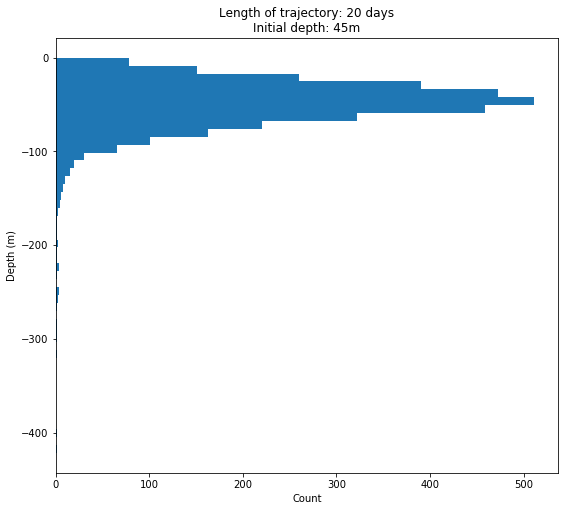

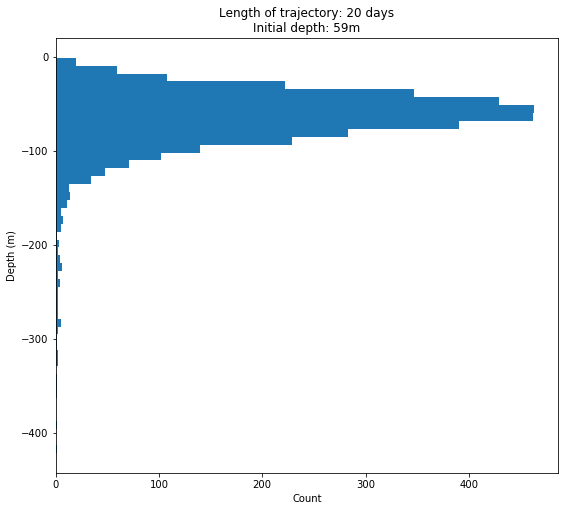

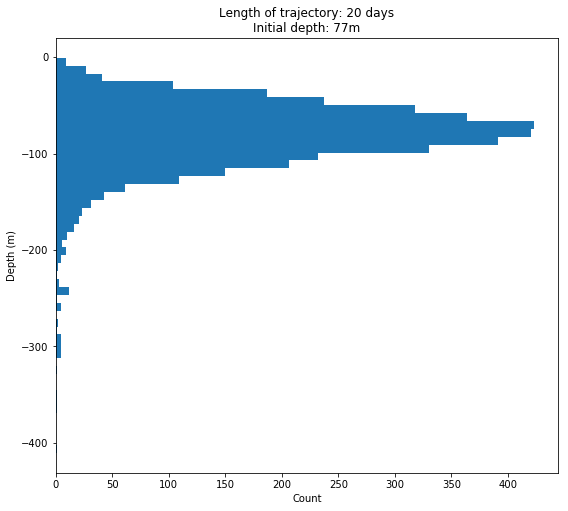

In [13]:
year1 = syear[0]
year2 = syear[1]
year3 = syear[2]

plot_hist(pts = year1, nday = nday, init_depth = 45)
plot_hist(pts = year2, nday = nday, init_depth = 59)
plot_hist(pts = year3, nday = nday, init_depth = 77)

In [18]:
nday = 30

syear = separate(nday)



start 20160101_20160131_427d:  2017-04-21 16:54:04.184753
time:  0:03:46.271753
start 20160201_20160229_401d:  2017-04-21 16:57:50.457489
time:  0:03:31.792839
start 20160301_20160331_355d:  2017-04-21 17:01:22.251309
time:  0:03:06.156486
start 20160401_20160430_325d:  2017-04-21 17:04:28.408865
time:  0:02:54.466362
start 20160501_20160531_294d:  2017-04-21 17:07:22.876654
time:  0:02:55.559992
start 20160601_20160630_264d:  2017-04-21 17:10:18.437811
time:  0:02:16.147899
start 20160701_20160731_252d:  2017-04-21 17:12:34.587107
time:  0:02:11.723564
start 20160801_20160831_217d:  2017-04-21 17:14:46.311838
time:  0:01:52.505723
start 20160901_20160930_172d:  2017-04-21 17:16:38.819165
time:  0:01:25.015953
start 20161001_20161031_141d:  2017-04-21 17:18:03.836209
time:  0:01:12.503795
start 20161101_20161130_111d:  2017-04-21 17:19:16.341441
time:  0:00:55.330200
start 20161201_20161231_95d:  2017-04-21 17:20:11.673004
time:  0:00:48.505566


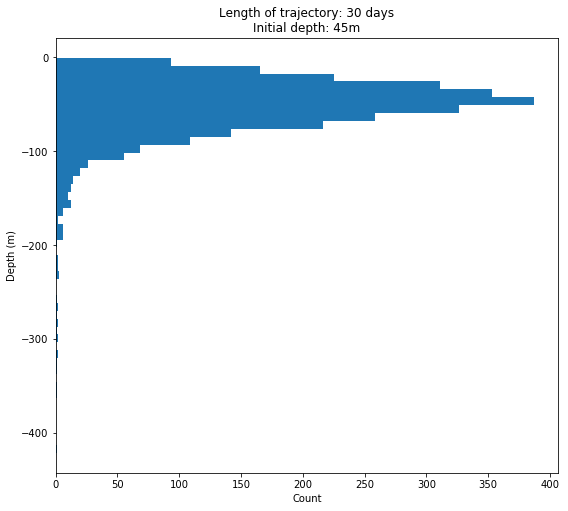

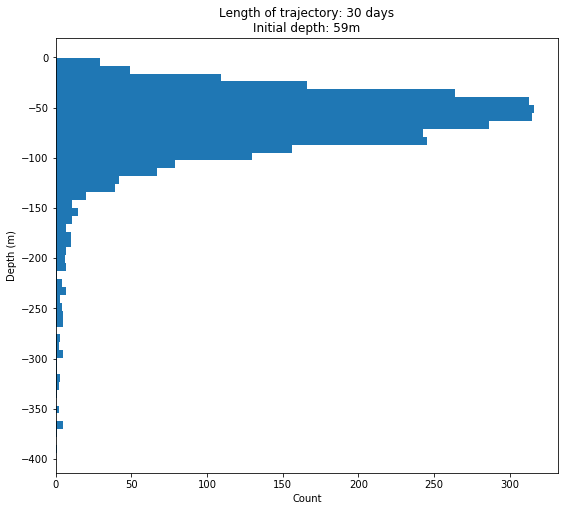

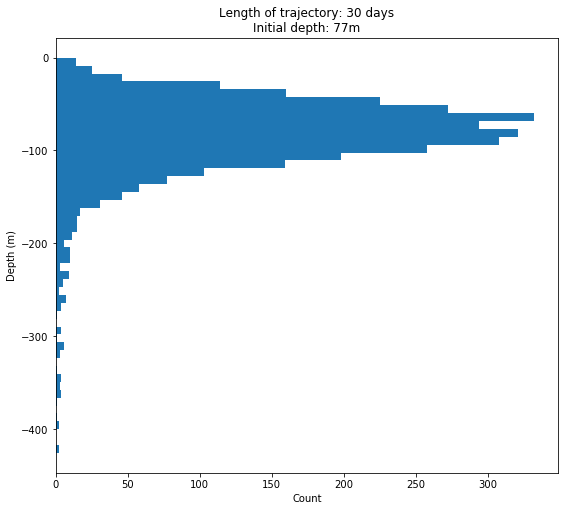

In [19]:
year1 = syear[0]
year2 = syear[1]
year3 = syear[2]

plot_hist(pts = year1, nday = nday, init_depth = 45)
plot_hist(pts = year2, nday = nday, init_depth = 59)
plot_hist(pts = year3, nday = nday, init_depth = 77)

In [20]:
print (len(year1), len(year2), len(year3))

8496 8496 8495


In [21]:
nday = 40

syear = separate(nday)

start 20160101_20160131_427d:  2017-04-21 17:21:01.235633
time:  0:03:38.299122
start 20160201_20160229_401d:  2017-04-21 17:24:39.781951
time:  0:03:18.105931
start 20160301_20160331_355d:  2017-04-21 17:27:57.888906
time:  0:02:55.445124
start 20160401_20160430_325d:  2017-04-21 17:30:53.334767
time:  0:02:36.333183
start 20160501_20160531_294d:  2017-04-21 17:33:29.668946
time:  0:02:23.801446
start 20160601_20160630_264d:  2017-04-21 17:35:53.471413
time:  0:02:05.036151
start 20160701_20160731_252d:  2017-04-21 17:37:58.508526
time:  0:02:03.243252
start 20160801_20160831_217d:  2017-04-21 17:40:01.752587
time:  0:01:46.019475
start 20160901_20160930_172d:  2017-04-21 17:41:47.772919
time:  0:01:20.904346
start 20161001_20161031_141d:  2017-04-21 17:43:08.678154
time:  0:01:09.105226
start 20161101_20161130_111d:  2017-04-21 17:44:17.784396
time:  0:00:52.997089
start 20161201_20161231_95d:  2017-04-21 17:45:10.782403
time:  0:00:47.101570


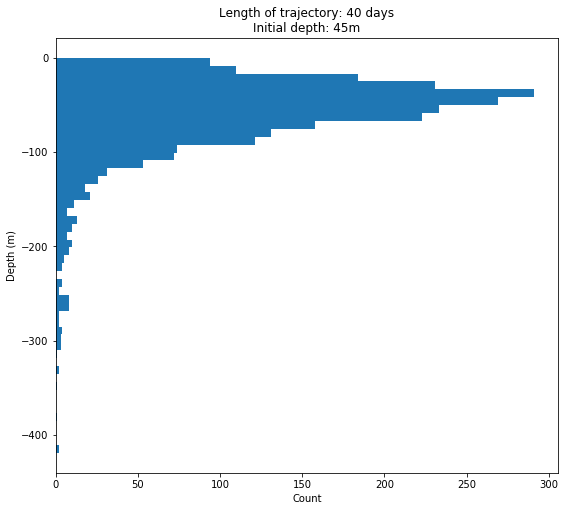

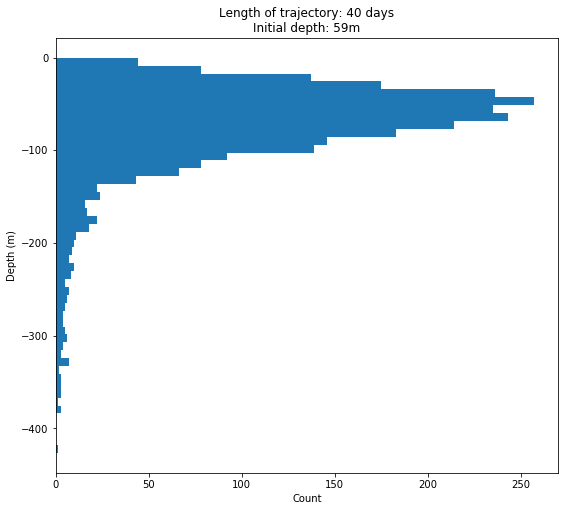

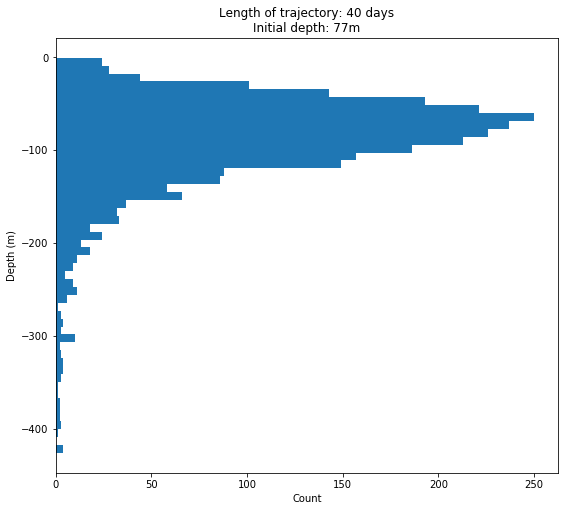

In [22]:
year1 = syear[0]
year2 = syear[1]
year3 = syear[2]

plot_hist(pts = year1, nday = nday, init_depth = 45)
plot_hist(pts = year2, nday = nday, init_depth = 59)
plot_hist(pts = year3, nday = nday, init_depth = 77)

In [23]:
print (len(year1), len(year2), len(year3))

8496 8496 8495


In [24]:
nday = 50

syear = separate(nday)

start 20160101_20160131_427d:  2017-04-21 17:45:58.885588
time:  0:03:35.446381
start 20160201_20160229_401d:  2017-04-21 17:49:34.332931
time:  0:03:09.403787
start 20160301_20160331_355d:  2017-04-21 17:52:43.737550
time:  0:03:00.845272
start 20160401_20160430_325d:  2017-04-21 17:55:44.583709
time:  0:02:39.647991
start 20160501_20160531_294d:  2017-04-21 17:58:24.232517
time:  0:02:28.672255
start 20160601_20160630_264d:  2017-04-21 18:00:52.905741
time:  0:02:10.370955
start 20160701_20160731_252d:  2017-04-21 18:03:03.277675
time:  0:02:08.652326
start 20160801_20160831_217d:  2017-04-21 18:05:11.931008
time:  0:01:51.191361
start 20160901_20160930_172d:  2017-04-21 18:07:03.123345
time:  0:01:23.324006
start 20161001_20161031_141d:  2017-04-21 18:08:26.448324
time:  0:01:10.881520
start 20161101_20161130_111d:  2017-04-21 18:09:37.330670
time:  0:00:54.663248
start 20161201_20161231_95d:  2017-04-21 18:10:31.994836
time:  0:00:48.265884


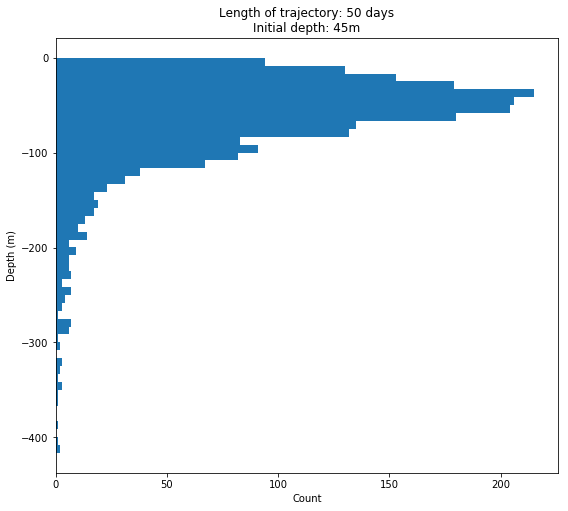

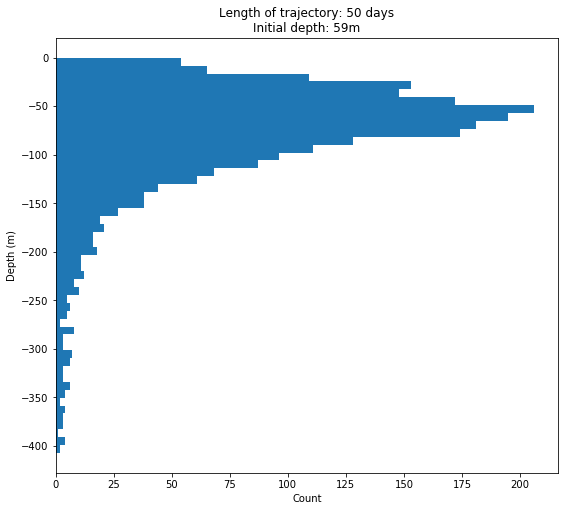

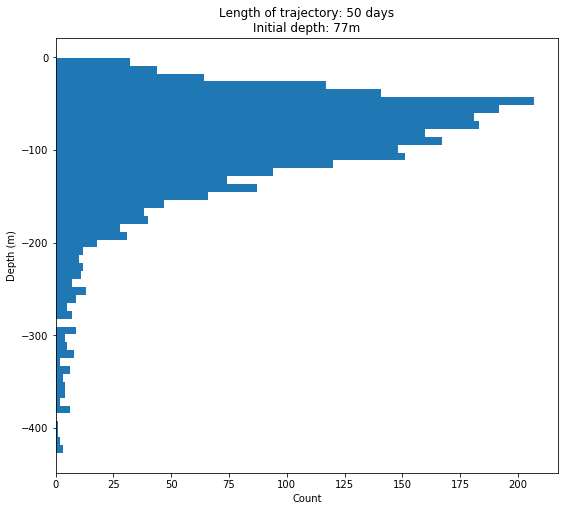

In [25]:
year1 = syear[0]
year2 = syear[1]
year3 = syear[2]

plot_hist(pts = year1, nday = nday, init_depth = 45)
plot_hist(pts = year2, nday = nday, init_depth = 59)
plot_hist(pts = year3, nday = nday, init_depth = 77)

In [27]:
nday = 100

# uncomment for test: 
dirs = dirs [0:3]

syear = separate(nday)

start 20160101_20160131_427d:  2017-05-30 11:53:34.516533
time:  0:03:11.043395
start 20160201_20160229_401d:  2017-05-30 11:56:45.561062
time:  0:03:27.746978
start 20160301_20160331_355d:  2017-05-30 12:00:13.309149
time:  0:03:20.625493


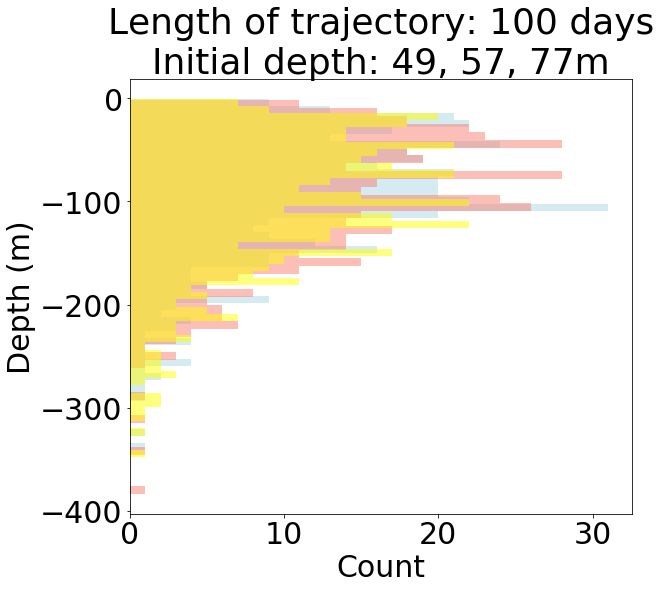

In [41]:
plt.clf()

year1 = syear[0]
year2 = syear[1]
year3 = syear[2]


plot_hist_together(pts1 = year1, pts2 = year2, pts3 = year3, nday = 100, init_depth = "49, 57, 77")

KeyboardInterrupt: 

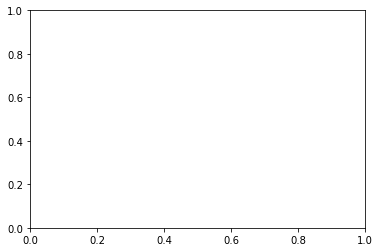

In [50]:
alt_plot(pts1 = year1, pts2 = year2, pts3 = year3, nday = 100, init_depth = "49, 57, 77")

In [26]:
print (len(year1), len(year2), len(year3))

8496 8496 8495


In [ ]:
#cant run this cell before rerunning Ariane so that December has at least 100 days
# nday = 100
# syear = separate(nday)

In [ ]:
bins = 50
plt.hist(year1, bins, alpha=0.5, label='45')

NameError: name 'plt' is not defined